In [1]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
DIR = "/home/claudio/hdd/git/bachelorThesis/figure_9/"

In [3]:
LABELS = {"task_count": "Number of tasks", 
          "interval": "Job execution time",
          "machine_locality": "Machine locality"}

def categorical_plot(df, key, title, sorted_xs = None):
    if sorted_xs == None:
        xs = set()
        lines = []
        for t in [4,5,6,7]:
            xs = xs.union(np.array(df[df.term == t][key]).reshape(-1))
        xs = [str(x) for x in sorted(xs)]
    else:
        xs = sorted_xs
        
    plt.figure(figsize=(4,3))
    ax = plt.gca()
    plt.xlabel(LABELS[key])
    plt.ylabel("Event rate [%]")
    lines = []
    for t in [4,5,6,7]:
        ys = []
        for x in xs:
            partsum = df[(df.term != -1) & (df[key] == x)]["count"].sum().astype(int)
            y = df[(df.term == t) & (df[key] == x)]["count"]
            ys.append((y.values.astype(int)[0] / partsum if partsum > 0 else y.values.astype(int)[0]) if y.any() else 0)
            ys[-1] *= 100
        lines.append(ax.plot(xs,ys, marker='.')[0])

    plt.xticks(xs)
    plt.yticks([0,20,40,60,80,100])
    lgd = plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL"],
              bbox_to_anchor=(1,1))
    if cluster == "all":
        plt.title("2019 data")
    elif cluster == "2011":
        plt.title("2011 data")
    else:
        plt.title("Cluster " + cluster.upper())
        
    plt.savefig('../report/figures/figure_9/%s-%s.pgf' % 
            (key.replace("_", ""), cluster), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

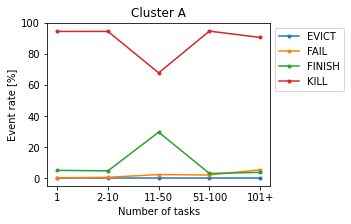

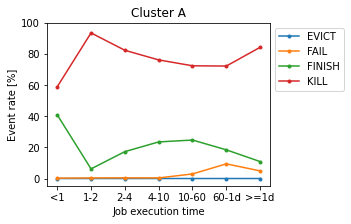

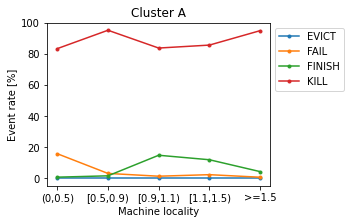

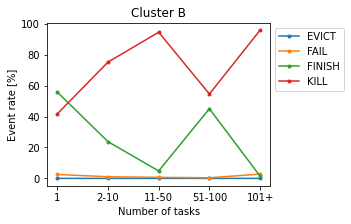

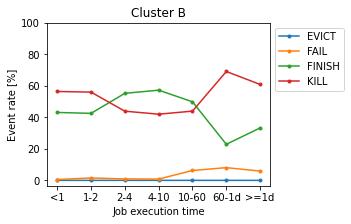

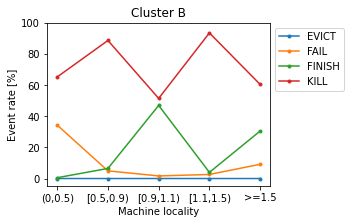

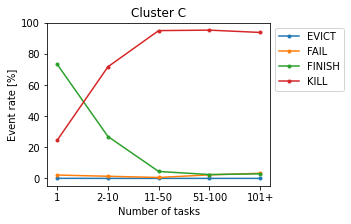

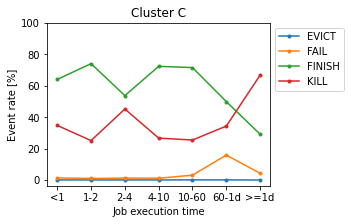

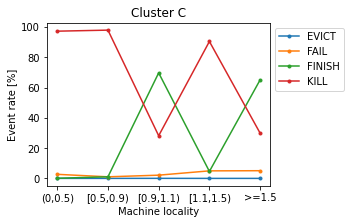

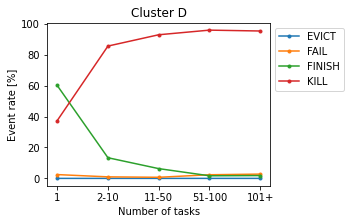

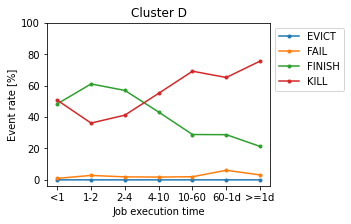

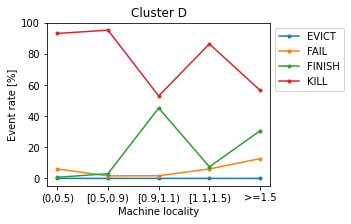

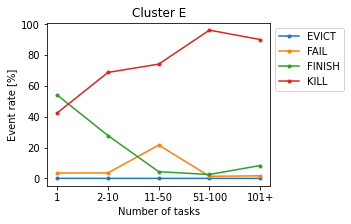

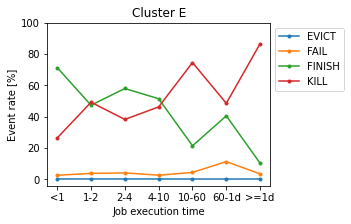

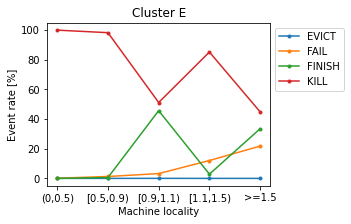

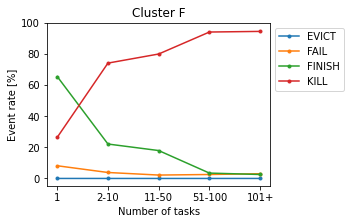

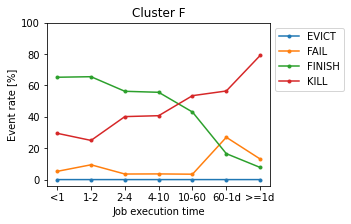

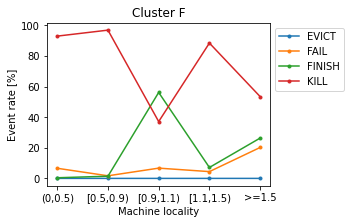

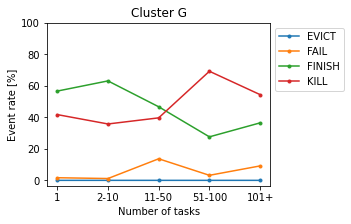

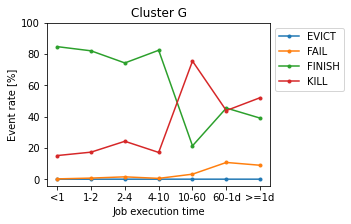

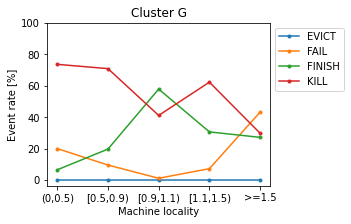

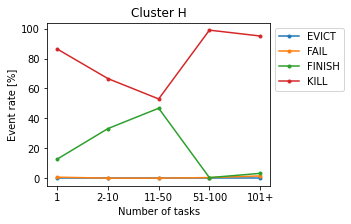

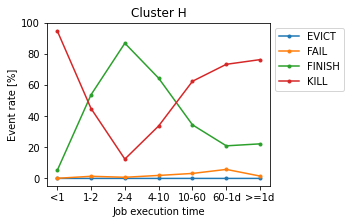

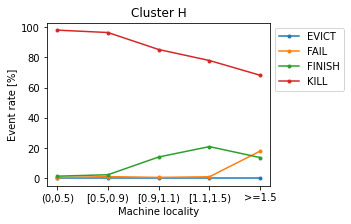

In [4]:
def to_9a_bin(col):
    # 1 [2,10] [11,50] [51,100] 101+
    if col <= 0:
        return "None known"
    elif col == 1:
        return "1"
    elif col <= 10:
        return "2-10"
    elif col <= 50:
        return "11-50"
    elif col <= 100:
        return "51-100"
    else:
        return "101+"
    
def to_9c_bin(col):
    # 1 [2,10] [11,50] [51,100] 101+
    if col <= 0:
        return "Unknown"
    elif col < 0.5:
        return "(0,0.5)"
    elif col < 0.9:
        return "[0.5,0.9)"
    elif col < 1.1:
        return "[0.9,1.1)"
    elif col < 1.5:
        return "[1.1,1.5)"
    else:
        return ">=1.5"
    
dfatot = None
dfbtot = None
dfctot = None

for cluster in "abcdefgh":
    dfa = pd.read_csv(DIR + cluster + "_term_task_count.csv") \
        .sort_values(["term", "task_count"])
    dfa = dfa[dfa["task_count"] > 0]
    dfa = dfa[dfa["term"].isin(range(4,8))]
    dfa["task_count"] = dfa["task_count"].apply(to_9a_bin)
    dfa = dfa.groupby(["term", "task_count"]).sum().reset_index()
    if dfatot is None:
        dfatot = dfa
    else:
        dfatot = dfatot.append(dfa)
    
    categorical_plot(dfa, "task_count", "# of tasks w.r.t. job rate (cluster " + 
                     cluster + ")", [to_9a_bin(x) for x in [1,10,50,100,101]])
    
    # column should be called machine_count here, typo in analysis scripts
    dfb = pd.read_csv(DIR + cluster + "_priority_exectime/part-00000", header=None,
                names=["term", "priority", "interval", "count"]).sort_values(["term", "interval"])
    del dfb["priority"]
    dfb = dfb.groupby(["term", "interval"]).sum().reset_index()
    dfb = dfb[dfb["term"].isin(range(4,8))]
    if dfbtot is None:
        dfbtot = dfb
    else:
        dfbtot = dfbtot.append(dfb)
   
    xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
    categorical_plot(dfb, "interval", "Job execution time (in mins) w.r.t. job rate (cluster " + 
                     cluster + ")", xs)
      
    dfc = pd.read_csv(DIR + cluster + "_term_machine_locality.csv") \
        .sort_values(["term", "machine_locality"])
    dfc= dfc[dfc["machine_locality"] > 0]
    dfc["machine_locality"] = dfc["machine_locality"].apply(to_9c_bin)
    dfc = dfc.groupby(["term", "machine_locality"]).sum().reset_index()
    dfc = dfc[dfc["term"].isin(range(4,8))]
    if dfctot is None:
        dfctot = dfc
    else:
        dfctot = dfctot.append(dfc)
    
    categorical_plot(dfc, "machine_locality", "Machine locality w.r.t. job rate (cluster " + 
                     cluster + ")", [to_9c_bin(x) for x in [0.49,0.89,1.09,1.49,1.5]])  

    term task_count    count
0      4          1     2686
1      5          1   375924
2      5       101+    30652
3      5      11-50    25790
4      5       2-10    32493
5      5     51-100     5781
6      6          1  8746326
7      6       101+    41178
8      6      11-50   121019
9      6       2-10   493786
10     6     51-100    45858
11     7          1  7004985
12     7       101+   865662
13     7      11-50   677346
14     7       2-10  1824913
15     7     51-100   272201
    term interval     count
0      4      1-2      1272
1      4    10-60      3849
2      4      2-4      1012
3      4     4-10      1381
4      4    60-1d       670
5      4       <1      3401
6      4     >=1d        16
7      5      1-2    212983
8      5    10-60    556418
9      5      2-4    139020
10     5     4-10    156903
11     5    60-1d    678146
12     5       <1    303335
13     5     >=1d     36972
14     6      1-2   6186670
15     6    10-60   7480361
16     6      2-4   4988230
17 

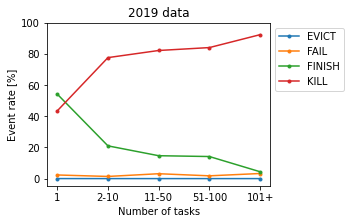

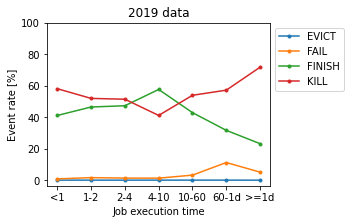

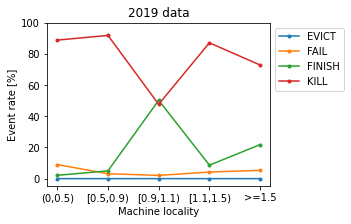

In [5]:
cluster = "all"

dfatot = dfatot.groupby(["term", "task_count"]).sum().reset_index()
dfbtot = dfbtot.groupby(["term", "interval"]).sum().reset_index()
dfctot = dfctot.groupby(["term", "machine_locality"]).sum().reset_index()

print(dfatot)
print(dfbtot)
print(dfctot)

categorical_plot(dfatot, "task_count", None, [to_9a_bin(x) for x in [1,10,50,100,101]])

xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
categorical_plot(dfbtot, "interval", None, xs)

categorical_plot(dfctot, "machine_locality", None, [to_9c_bin(x) for x in [0.49,0.89,1.09,1.49,1.5]]) 

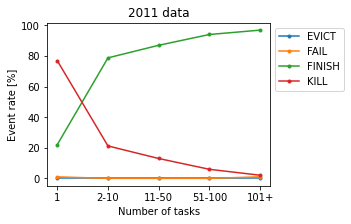

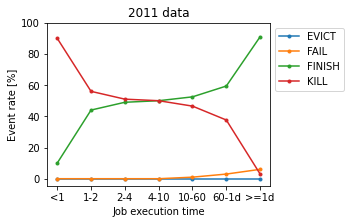

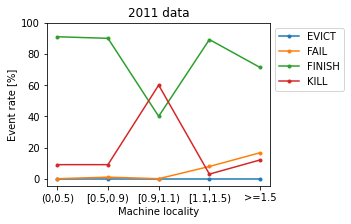

In [6]:
def malusa(l, r):
    return [a for a in itertools.chain(*[[b for x in range(r)] for b in l])]

dfa11 = {'term': [x for x in range(4,8)] * 5,
         'task_count': malusa(["1", "2-10", "11-50", "51-100", "101+"], 4),
         'count': [0,1,22,77,
                   0,0,78,21,
                   0,0,87,13,
                   0,0,95,6,
                   0,1,94,2]}
dfa11 = pd.DataFrame(data=dfa11, columns=dfa11.keys())

dfc11 = {'term': [x for x in range(4,8)] * 5,
         'machine_locality': malusa([to_9c_bin(x) for x in [0.49,0.89,1.09,1.49,1.5]], 4),
         'count': [0,0,91,9,
                   0,1,90,9,
                   0,0,40,60,
                   0,8,91,3,
                  0,18,77,13]}
dfc11 = pd.DataFrame(data=dfc11, columns=dfc11.keys())

dfb11 = {'term': [x for x in range(4,8)] * 7,
         'interval': malusa(["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"], 4),
         'count': [0,0,10,90,
                  0,0,44,56,
                  0,0,49,51,
                  0,0,50,50,
                  0,1,53,47,
                  0,3,60,38,
                  0,6,91,3]}
dfb11 = pd.DataFrame(data=dfb11, columns=dfb11.keys())

cluster = "2011"

categorical_plot(dfa11,"task_count", None, [to_9a_bin(x) for x in [1,10,50,100,101]])

xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
categorical_plot(dfb11, "interval", None, xs)

categorical_plot(dfc11, "machine_locality", None, [to_9c_bin(x) for x in [0.49,0.89,1.09,1.49,1.5]]) 